# Computational Intelligence CI2024_lab2
> - Author: Daniel Bologna
> - ID: 310582

## The Traveling Salesman Problem
- [Travelling salesman problem - Wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

### Import libraries

In [1396]:
import logging
from itertools import combinations # Return r length subsequences of elements from the input iterable.
import pandas as pd
import numpy as np
from geopy.distance import geodesic ## compute distance between points
import networkx as nx
import matplotlib.pyplot as plt

from icecream import ic

logging.basicConfig(level=logging.DEBUG)

from dataclasses import dataclass

from enum import Enum

### Load Cities

In [1397]:
def _load_cities(city_name : str) -> tuple[pd.DataFrame, np.ndarray]:
    """Loads TSP cities from CSV file.
    Args:
        city_file_path (str): The name of the city.
    Returns:
        tuple[pd.DataFrame, np.ndarray]
    """
    CITIES = pd.read_csv(f'cities/{city_name}.csv', header=None, names=['name', 'lat', 'lon'])
    DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
    for c1, c2 in combinations(CITIES.itertuples(), 2):
        DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km
    return CITIES, DIST_MATRIX

def _to_pandas_table(matrix, x_names=None, y_names=None):
    """Returns a dataframe from a matrix"""
    return pd.DataFrame(matrix, index=x_names, columns=y_names)

In [1398]:
city_name = "us"
CITIES, DIST_MATRIX = _load_cities(city_name)
CITIES.head(10)

,name,lat,lon
0,Abilene,32.454514,-99.738147
1,Akron,41.080456,-81.521429
2,Albuquerque,35.105552,-106.647388
3,Alexandria,38.818343,-77.082026
4,Allen,33.107224,-96.674676
5,Allentown,40.593966,-75.478160
6,Amarillo,35.197840,-101.828746
7,Amherst,43.011639,-78.757148
8,Anaheim,33.836165,-117.889769
9,Anchorage,61.177549,-149.274354


In [1399]:
#_to_pandas_table(DIST_MATRIX, [str(_) for _ in CITIES['name']], [str(_) for _ in CITIES['name']])

In [1400]:
def tsp_cost(tsp : np.ndarray) -> float:
    """Compute the cost of the path as the sum of the cities' distances."""
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0.0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

# Visualization

Simple function that plot a graph

In [1401]:
def _print_graph(solution, points=True, lines=True, p_color = "red", l_color = "red", title=""):
    """Plot the graph from a coordinate matrix"""
    coord = [
        [CITIES.at[i, "lon"] for i in solution],
        [CITIES.at[i, "lat"] for i in solution]
    ]
    plt.axis("off")
    plt.title(title)
    if points: plt.scatter( coord[0], coord[1], color=p_color)
    if lines: plt.plot( coord[0], coord[1], color=l_color)
    plt.show()

In [1402]:
def fitness(sequence):
    return -tsp_cost(sequence)

# Nearest Neighbor approach

> Start from a point, then choose the nearest point in the list of cities. Repeat until completion. 

ic| final_cost: '46244.33295267395 km'


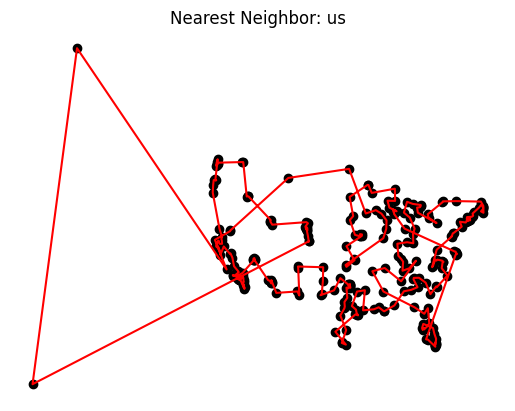

In [1403]:
def _nn_approach(cities, dist_mat):
    visited = np.full(len(cities), False)
    dist = dist_mat.copy()

    # Choose a random city to start
    city = np.random.randint(0, len(cities))

    # Create a solution as a list of integers (city's index)
    tsp_sol = list()

    # Append the first city to the solution and mark as visited
    tsp_sol.append(int(city))
    visited[city] = True

    while not np.all(visited):
        # Set the city's column as inf distance to avoid 
        # calculating the distance between a city and itself
        dist[:, city] = np.inf

        # Find the closest city
        closest = np.argmin(dist[city])

        # Mark it as visited, push it to the solution and se the current city as the closest
        visited[closest] = True
        city = closest
        tsp_sol.append(int(city))

    # In the end add the first city at the end to create a cycle
    tsp_sol.append(int(tsp_sol[0]))
    return tsp_sol

EPOCHS = 1000
tsp_sol = _nn_approach(CITIES, DIST_MATRIX)
tsp_fit = fitness(tsp_sol)
for i in range(EPOCHS):
    new_tsp_sol = _nn_approach(CITIES, DIST_MATRIX)
    new_tsp_fit = fitness(new_tsp_sol)
    if new_tsp_fit > tsp_fit:
        tsp_sol = new_tsp_sol
        tsp_fit = new_tsp_fit

# Print the result and plot the graph
final_cost = f"{abs(tsp_fit)} km"
ic(final_cost)
_print_graph(tsp_sol, p_color="black", title=f"Nearest Neighbor: {city_name}")

# EA approach

In [1404]:
@dataclass # this is a decorator https://www.geeksforgeeks.org/decorators-in-python/
class Individual:
    genome: np.ndarray
    fitness : float = None

In [1405]:
# SETTINGS
class SEL_TYPE(Enum):
    UNIFORM = 0
    TOURNAMENT = 1

class XO_TYPE(Enum):
    INV_OVER = 1

class MUT_TYPE(Enum):
    INSERT = 1


POPULATION_SIZE = 100
OFFSPRING_SIZE = 10
MAX_GENERATIONS = 1_000
GEN_OP_PROBABILITY = 0.5

In [1406]:
def parent_selection(population, type=SEL_TYPE.UNIFORM, tournament_size=2):
    if type == SEL_TYPE.UNIFORM:
        candidates = sorted(population, key=lambda c: c.fitness, reverse=True)
        return candidates[0]
    if type == SEL_TYPE.TOURNAMENT:
        candidates = sorted(np.random.choice(population, tournament_size),
                            key=lambda c: c.fitness,
                            reverse=True)
        return candidates[0]
        

def mutation(p, type=MUT_TYPE.INSERT):
    if type == MUT_TYPE.INSERT:
        # get two random elements
        indices = sorted(np.random.choice(p.genome, 2, replace=False), key=lambda x:x)

        o = p.genome[0:indices[0]] + [p.genome[indices[0]],p.genome[indices[1]]] + p.genome[indices[0] + 1: indices[1]] + p.genome[indices[1] + 1: len(p.genome)]
        return Individual(genome=o, fitness=fitness(o+[o[0]]))

def xover(p1, p2, type=XO_TYPE.INV_OVER):
    """Simple invert over crossover"""
    if type == XO_TYPE.INV_OVER:
        # Get random edge from second parent
        index = np.random.randint(0, len(p2.genome) - 1)
        edge = [p2.genome[index], p2.genome[index+1]]

        # get the edge's vertices indices from the first parent
        edge_inices = [p1.genome.index(i) for i in edge]
        edge_inices = sorted(edge_inices, key=lambda x: x)

        # combine the data to get the offspring
        o = p1.genome[0:edge_inices[0]] + edge + p1.genome[edge_inices[0]+1:edge_inices[1]][::-1] + p1.genome[edge_inices[1]+1:len(p1.genome)]
        return Individual(genome=o, fitness=fitness(o+[o[0]]))

In [1407]:
# Generate population
def init_population():
    population = list()
    for i in range(POPULATION_SIZE):
        genome = _nn_approach(CITIES, DIST_MATRIX)[: len(CITIES)]
        population.append(Individual(genome=genome, fitness=fitness(genome + [genome[0]]))) # leve out the last item but consider it for the fitness
    return population

## Hyper modern approach

In [1408]:
def _step(population):
    offspring = list()
    
    # PARENT SELECTION and RECOMBINATION
    for _ in range(OFFSPRING_SIZE):
        # USING ULTRA MODERN APPROACH:
        # RANDOMLY CHOOSE GENETIC OP
        if np.random.random() < GEN_OP_PROBABILITY:
            # DO MUTATION
            # take 1 parent
            p = parent_selection(population, type=SEL_TYPE.TOURNAMENT, tournament_size=2)
            # mutate the parent to get the offspring
            o = mutation(p)
        else:
            # DO XOVER
            # take 2 parents
            p1 = parent_selection(population, type=SEL_TYPE.TOURNAMENT, tournament_size=2)
            p2 = parent_selection(population, type=SEL_TYPE.TOURNAMENT, tournament_size=2)
            # recombine them
            o = xover(p1, p2)
        
        # put the result in the offspring
        offspring.append(o)

    # for i in offspring:
    #     # evaluate new fitnes
    #     i.fitness = fitness(i)

    # in the end add the newly generated offspring to the population
    population.extend(offspring)
    population.sort(key=lambda i : i.fitness, reverse=True)

    # go for a simple survivor selection and return to the population size
    population = population[:POPULATION_SIZE]

    return population

ic| tsp_cost(best_sol): 46556.674346247186


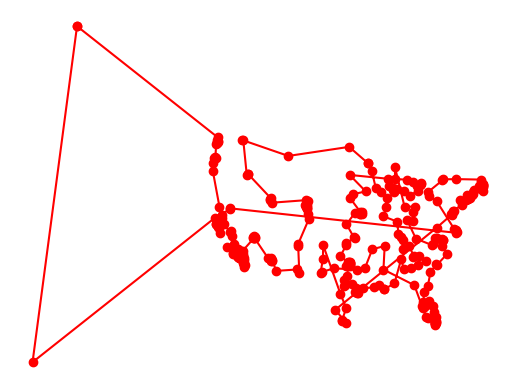

In [1409]:
starting_population = init_population()
current_solution = starting_population.copy()
for i in range(MAX_GENERATIONS):
    current_solution = _step(current_solution)

best_sol = current_solution[0].genome
best_sol = best_sol + [best_sol[0]]

ic(tsp_cost(best_sol))
_print_graph(best_sol)